In [1]:
#   IMPORTS Y CONFIG
# ==============================
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from time import time

In [27]:
# Activar mixed precision si tienes GPU moderna (opcional)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [28]:
#   CARGA DE HDF5
# ==============================
# Para Colab: descomenta estas dos líneas
'''
from google.colab import drive
drive.mount('/content/drive')
h5_file = '/content/drive/MyDrive/data/Galaxy10_DECals_NoDuplicated.h5'
'''

h5_file = os.path.join("data", "Galaxy10_DECals_NoDuplicated.h5")
h5 = h5py.File(h5_file, "r")

images = h5["images"]      # dejar como HDF5, no cargar todo a RAM
labels = h5["ans"]
redshift = h5["redshift"]
pxscale = h5["pxscale"]

N = images.shape[0]
print("Total imágenes:", N)

Total imágenes: 17675


In [29]:
#   SPLIT train/val/test
# ==============================
indices = np.arange(N)
np.random.seed(42)
np.random.shuffle(indices)

train_end = int(0.7 * N)
val_end   = int(0.85 * N)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

Train: 12372, Val: 2651, Test: 2652


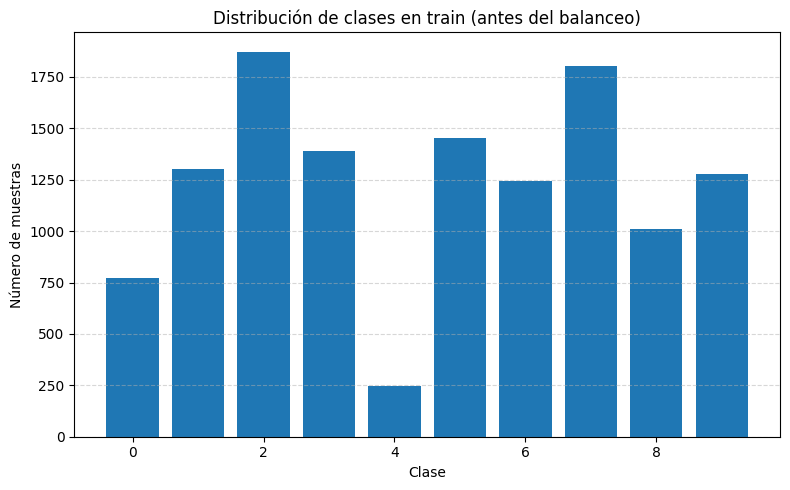

In [ ]:
#   DISTRIBUCIÓN DE CLASES ORIGINAL

train_labels = np.array([labels[i] for i in train_idx])  # Extraemos las etiquetas del conjunto TRAIN
classes, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(8,5))
plt.bar(classes, counts)
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.title("Distribución de clases en train (antes del balanceo)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# ==============================
#   BALANCEO PREVIO (Offline)
#   - Undersampling de mayoritarias
#   - Oversampling simple de minoritarias
# ==============================
train_labels = np.array([labels[i] for i in train_idx])
unique_classes, counts = np.unique(train_labels, return_counts=True)

min_target = 800  # objetivo por clase, configurable
balanced_indices = []

for c, cnt in zip(unique_classes, counts):
    class_indices = train_idx[train_labels == c]

    if cnt > min_target:
        # Undersampling
        sel = np.random.choice(class_indices, min_target, replace=False)
    else:
        # Oversampling
        reps = int(np.ceil(min_target / cnt))
        sel = np.random.choice(class_indices, min_target, replace=True)
    
    balanced_indices.extend(sel)

balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)

print("Nuevo tamaño de entrenamiento equilibrado:", len(balanced_indices))



Nuevo tamaño de entrenamiento equilibrado: 8000


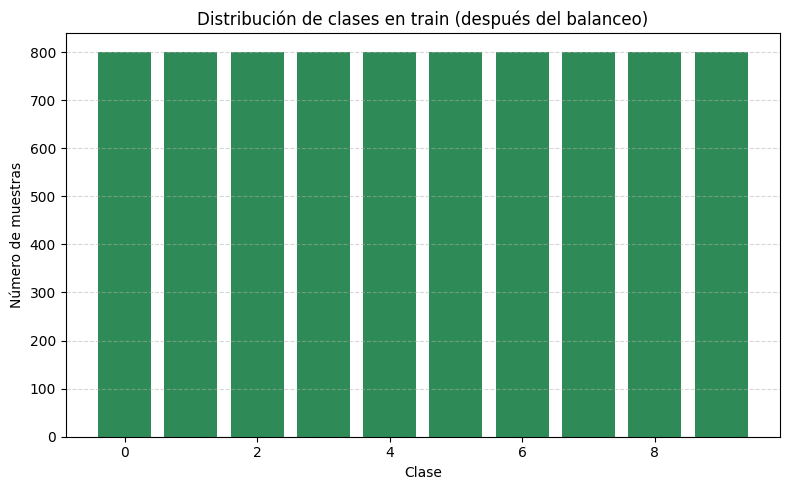

In [36]:
#   DISTRIBUCIÓN TRAS BALANCEO OFFLINE
# ==============================
balanced_labels = np.array([labels[i] for i in balanced_indices])
classes_bal, counts_bal = np.unique(balanced_labels, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(classes_bal, counts_bal, color="seagreen")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.title("Distribución de clases en train (después del balanceo)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [39]:
#   PRE-PROCESAMIENTO
# ==============================

IMG_SIZE = 128
batch_size = 32

def preprocess(idx):
    def _load_numpy(i):
        # Devuelve imágenes y tabulares como NumPy arrays
        img = images[i]         # HDF5 indexing
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE]).numpy() / 255.0
        tab = np.array([redshift[i], pxscale[i]], dtype=np.float32)
        lbl = np.array(labels[i], dtype=np.int32)
        return img, tab, lbl

    img, tab, lbl = tf.py_function(_load_numpy, [idx], [tf.float32, tf.float32, tf.int32])
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    tab.set_shape([2])
    lbl.set_shape([])
    return (img, tab), lbl

# Augment solo imágenes
aug_layers = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

def augment(inputs, lbl):
    img, tab = inputs
    return (aug_layers(img), tab), lbl

In [40]:
#   CREACIÓN DE DATASETS con tf.data
# ==============================

def create_dataset(indices, augment_data=False):
    ds = tf.data.Dataset.from_tensor_slices(indices)
    ds = ds.shuffle(len(indices))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(balanced_indices, augment_data=True)
val_ds = create_dataset(val_idx)
test_ds = create_dataset(test_idx)

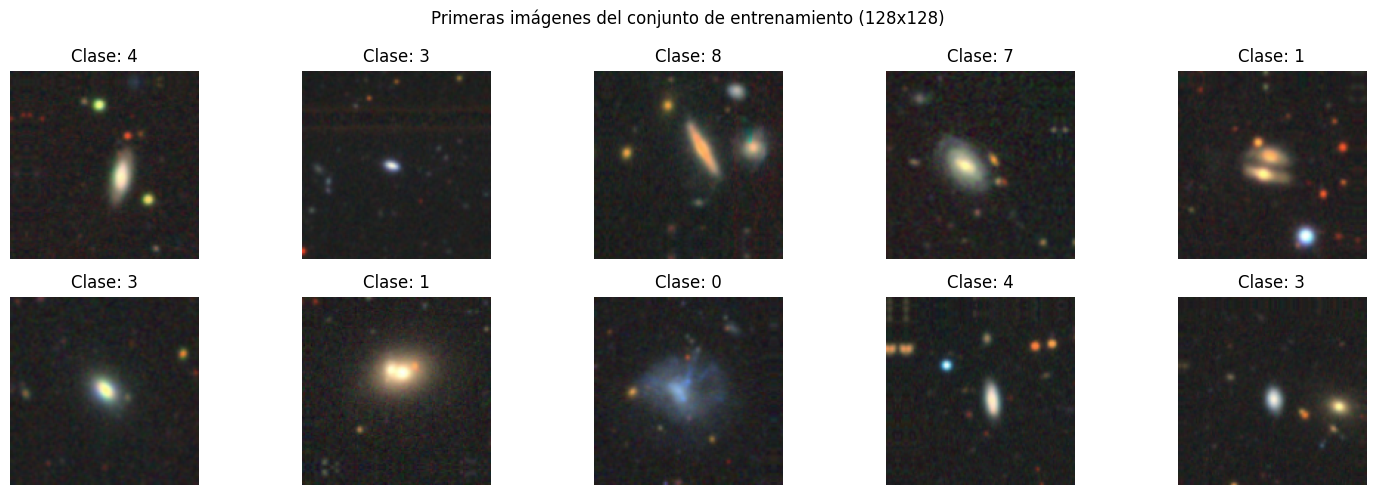

In [44]:
#   VISUALIZACIÓN EJEMPLOS TRAIN
# ==============================
# Extraemos un batch del dataset (ya con resize)

batch = next(iter(train_ds))
(batch_imgs, batch_tabs), batch_lbls = batch

plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(batch_imgs[i].numpy().astype(np.float32))
    plt.title(f"Clase: {batch_lbls[i].numpy()}")
    plt.axis("off")

plt.suptitle("Primeras imágenes del conjunto de entrenamiento (128x128)")
plt.tight_layout()
plt.show()

In [45]:
#   MODELO EfficientNetB0 + tabulares
# ==============================
img_input = Input(shape=(IMG_SIZE,IMG_SIZE,3))
tab_input = Input(shape=(2,))

# Transfer learning
base_cnn = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=img_input)
base_cnn.trainable = False   # congelamos para acelerar

x = layers.GlobalAveragePooling2D()(base_cnn.output)
x = layers.Dense(256, activation="relu")(x)

t = layers.Dense(32, activation="relu")(tab_input)
t = layers.BatchNormalization()(t)
t = layers.Dense(16, activation="relu")(t)

combined = layers.concatenate([x,t])
combined = layers.Dense(128, activation="relu")(combined)
combined = layers.Dense(64, activation="relu")(combined)
output = layers.Dense(10, activation="softmax", dtype="float32")(combined)

model = Model(inputs=[img_input, tab_input], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 128, 128,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 128, 128,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,422,109 (16.87 MB)

 Trainable params: 372,474 (1.42 MB)

 Non-trainable params: 4,049,635 (15.45 MB)

In [46]:
#   ENTRENAMIENTO
# ==============================
from tensorflow.keras.callbacks import EarlyStopping

earlyS = EarlyStopping(patience=5, restore_best_weights=True)

t0 = time()
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[earlyS]
)
print("Tiempo total entrenamiento:", round(time()-t0,2), "seg")

Epoch 1/20
  2/250 ━━━━━━━━━━━━━━━━━━━━ 1:17:08 19s/step - accuracy: 0.0547 - loss: 2.3424

KeyboardInterrupt: 

In [ ]:
#   EVALUACIÓN EN TEST
# ==============================
y_true = []
y_pred = []

for batch in test_ds:
    imgs, tabs, lbls = batch
    preds = model.predict([imgs, tabs])
    y_true.extend(lbls.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize="true", cmap="Blues")
plt.show()

In [ ]:
#   GRÁFICAS DE ENTRENAMIENTO
# ==============================
plt.figure(figsize=(8,5))

# Pérdida (Loss)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")

plt.title("Evolución del Loss durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8,5))

# Accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")

plt.title("Evolución de la Accuracy durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
model.save("modelo_galaxias.keras")
model.save("modelo_galaxias.h5")
model.save("/content/drive/MyDrive/modelo_galaxias.keras")